# Name: Prabal Ghosh

## Inverse problems in image processing - TD 2
                                  
                                  e-mail: jayousi@unice.fr
                                  date: 19th Jan. 2024

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import laplace

In [2]:
def scale(img):
    return ((img - img.min())/(img.max() - img.min()) * 255)

def snr(xref, x):
    return 20 * np.log10(np.linalg.norm(xref) / np.linalg.norm(xref-x))

# 1. Introduction

## 1.1 Fourier Transform

Load and display the two images.

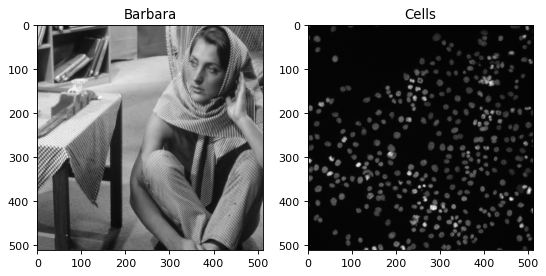

In [4]:
# load the images
x1 = np.float64(plt.imread('barbara.png'))
x2 = np.float64(plt.imread('cells.png'))

# rescale the images in the range 0-255
x1 = scale(x1)
x2 = scale(x2)

# plot the images
plt.figure(figsize=(8, 4), dpi=80)
plt.subplot(121)
plt.imshow(x1, cmap='gray')
plt.title('Barbara')
plt.subplot(122)
plt.imshow(x2, cmap='gray')
plt.title('Cells')
plt.show()

* Compute the FFT (Fast Fourier Transform) of the Barbara image.

In [4]:
import numpy.fft as fft

In [5]:
x1_hat = fft.fft2(x1)
x1_magnitude = np.absolute(x1_hat)
x1_phase = np.angle(x1_hat)


Text(0.5, 1.0, 'Barbara phase')

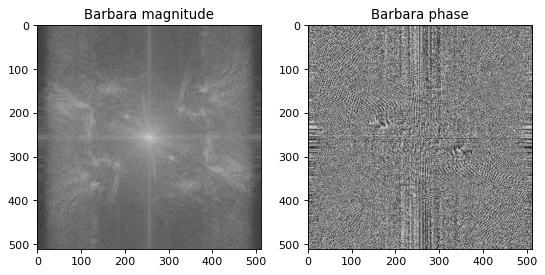

In [6]:
# plot the images
plt.figure(figsize=(8, 8), dpi=80)
plt.subplot(221)
plt.imshow(fft.fftshift(np.log(x1_magnitude)), cmap='gray')
plt.title('Barbara magnitude')
plt.subplot(222)
plt.imshow(fft.fftshift(x1_phase), cmap='gray')
plt.title('Barbara phase')


## 1.2 Noise Generation

Add noise, $\eta$, to the "Barbara" image where

$$\eta \sim \mathcal{N}(0, \sigma^2 I)$$

Plot the original and the noisy image.  

_Hint_: you can use the np.random.randn() function

In [7]:
sig = 150                     # SD of Gaussian noise

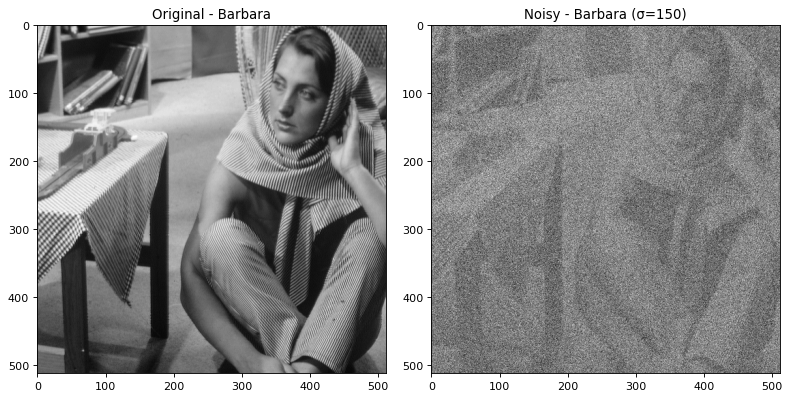

In [8]:
noise = sig * np.random.randn(*x1.shape)   #  Gaussian noise
x1_noisy = x1 + noise



plt.figure(figsize=(10, 5), dpi=80)

plt.subplot(121)
plt.imshow(x1, cmap='gray')
plt.title('Original - Barbara')

plt.subplot(122)
plt.imshow(x1_noisy, cmap='gray')
plt.title(f'Noisy - Barbara (σ={sig})')

plt.tight_layout()
plt.show()


* Compute the SNR between "Barbara" and its noisy version. 

In [9]:
def compute_snr(x_original, x_noisy):
    numerator = np.linalg.norm(x_original)
    denominator = np.linalg.norm(x_original - x_noisy)
    return 20 * np.log10(numerator / denominator)

In [10]:
snr = compute_snr(x1, x1_noisy)
print("the SNR between barbara and its noisy version: ",snr)

the SNR between barbara and its noisy version:  -1.2879615298202216


## 1.3 Image Blurring

We consider an image model where the observed image $y$ is a result of a degradation of an image $x$ by a linear transformation $f$, i.e.

$$
mat(y)=f(mat(x))
$$

where $mat(\cdot)$ is a notation used in this lab to underline that $f(mat(x))$ is an operation on a matrix $x$. 

Here $x$ and $y$ are images of size $512 \times 512$, then  $x\in \mathbb{R}^{512\times512}$ and  $y\in \mathbb{R}^{512\times512}$.

A common degradation is the blurring, achieved by convolving the image $x$ with a low-pass Gaussian filter kernel $h$. The blurred image $y$ is given by:

$$
mat(y)=mat(h)*mat(x) 
$$.

A common notation  is the matrix/vector notation:

$$
y= A x
$$

where $A$  is the matrix that does the convolution of the image $x$ by the Gaussian filter $h$. Here, $y$ and $x$ is the vectorized form of the images $mat(y)$ and $mat(x)$ respectiverly, in the lexical order. Then, $y\in \mathbb{R}^{N\times 1}$ and $x\in \mathbb{R}^{N\times 1}$ where $N$ is the number of pixels. It is important, as we will observe in the lab, that even though we use the notation for $A$, we do not actually construct the matrix. 

As you just observed, it is not always wise to create the full matrix $A$. So we will start by creating the function $f(mat(x))=mat(h)*mat(x)$, where $*$ denotes the convolution. Since convolution in time corresponds to multiplication in the frequency domain, we will do the convolution in the Fourier domain.

Compute the low pass Gaussian kernel with $\sigma=5$ pixels.  

The steps to create the convolution kernel is: 
1. Create a meshgrid of same size of the image (512x512). The center of the meshgrid could be 0. 
2. Apply the the Gaussian function onto the grid, and normalize the response such that the sum of all elements in the reponse =1. 
3. Apply the Fast Fourier Transformation. NOTE: If the center of the grid was defined as 0, a fftshift has to be done before applying the FFT2. 

In [11]:
sigma = 5
n = x1.shape[0]
t = np.concatenate( (np.arange(0, n/2+1), np.arange(-n/2, -1)) )

Y, X = np.meshgrid(t, t)
h = np.exp( -(X**2+Y**2)/(2.0*float(sigma)**2) )
h = h / np.sum(h)
hf = np.real(np.fft.fft2(h))

Plot the convolution kernel before and after the fourier transform in the Fourier domain.  

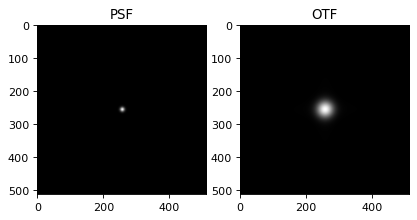

In [12]:
plt.figure(figsize=(6, 4), dpi=80)
plt.subplot(121)
plt.imshow(np.fft.fftshift(h), cmap='gray')
plt.title('PSF')
plt.subplot(122)
plt.imshow(np.fft.fftshift(hf), cmap='gray')
plt.title('OTF')
plt.show()

Compute the blurred image using periodic convolution with FFTs.

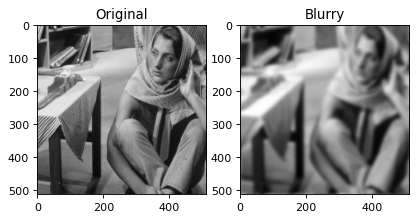

In [13]:
y1_bl = np.real(np.fft.ifft2(hf * np.fft.fft2(x1)))

plt.figure(figsize=(6, 4), dpi=80)
plt.subplot(121)
plt.imshow(x1, cmap='gray')
plt.title('Original')
plt.subplot(122)
plt.imshow(y1_bl, cmap='gray')
plt.title('Blurry')
plt.show()

# 2. Introduction to Inverse Problems

A more realistic model writes
$$
mat(y)=f(mat(x)) + mat(\eta) \qquad (1)
$$
where $mat(\cdot)$ is a notation used in this lab to underline that $f(mat(x))$ is an operation on a matrix $x$. 

A more common notation to write (1) is: 
$$
y= Ax + \eta
$$
where $A$ is the linear transformation and $x$, $y$ and $\eta$ are viewed as vectors. However, when working in image processing the matrix $A$ will rearly be constructed, and we will not reshape the image $x$ as a vector.  It is important, as we have observed in the lab, that even though we use the notations $A$, we do not actually construct the matrix. 

In this lab, we considerer that the noise, $\eta$ follows a multidimensional normal law of covarience $\sigma^2 I$ and of mean the zero vector. So, we can write: $\eta \sim \mathcal{N}(0, \sigma^2 I)$. 
  
The probability density function $p(\eta)$ is written as: 
\begin{equation}
 p(\eta) = \frac{1}{(2\pi\sigma^2)^{\frac{N}{2}}} \exp \left(-\frac{\|\eta\|_2^2}{2\sigma^2}\right)
\end{equation}
 where $N$ is the number of pixels and $\|\eta\|_p$ is the $l^p$-norm defined as: 
\begin{equation}
  \|\eta\|_p = \left(\sum_{i=1}^N |\eta|^p\right)^{\frac{1}{p}}
\end{equation}
 
 We want to find the unknown image $x$ from the observation $y$. Therefore, we use the  maximum likelihood estimation which maximizes the likelihood $L(y,x)$ with respect to the unknown image $x$. This likelihood is equal to the conditional probability of $y$ knowing $x$, denoted $p_{y|x}(y|x)$. The probability is calculated from the image model, supposing that the $\eta$ is white Gaussian noise. 

More precisely, the likelihood $L(y,x)$ is given by:
\begin{equation}
 L(y,x) = p_{y|x}(y|x) = p_n(n=Ax - y) = \frac{1}{(2\pi\sigma^2)^{\frac{N}{2}}} \textrm{exp}\left(-\frac{\|Ax-y\|_2^2}{2\sigma^2}\right)
\end{equation}

We search for an estimation $\hat{x}$ of the real image $x$ by maximizing the ligelihood  $L(y,x)$ as follows: 
\begin{equation}
 \hat{x} = \arg\max_x L(y,x)
\end{equation}

In order to avoid the difficulties related to the exponential, we often maximize the logarithm of the likelihood (which does not change the maximum argument since the logarithm is strictly increasing):
\begin{equation}
 \hat{x} = \arg\max_x \, \ln(L(y,x)) = \arg\max_x \, \left(- \ln \left(2\pi\sigma^2 \right)^{\frac{N}{2}} -\frac{1}{2\sigma^2}\|Ax-y\|_2^2\right)
\end{equation}

The term $- \ln \left( 2\pi\sigma^2 \right)^{\frac{N}{2}}$ is a constant with respect to $x$, and thus does not intervene in the estimation of $\arg\max$. Therefore, we can write:
\begin{equation}
 \hat{x} = \arg\max_x \, \left( -\frac{1}{2\sigma^2}\|Ax-y\|_2^2\right)
\end{equation}

The last step removes the proptionality coefficent $\frac{1}{2\sigma^2}$ and the negative sign by using the fact that  $\arg\max_x -f(x) = \arg\min_x f(x)$. So, finally: 

\begin{equation*}
 \hat{x} = \arg\min_x \, \|Ax-y\|_2^2 
\end{equation*}


Denote $J(x)=\|Ax-y\|_2^2 $. This term is in fact the Least Square term associated to the system $y = Ax$. The gradient of $J$ is $\nabla J(x)= 2A^*(Ax-y)$, where $A^*$ is the adjoint operator of A.

In order to find the minimum, instead of using Exact Least Square solution, we can make use of the gradient descent algorithm. The algorithm can be written as:

\begin{equation}
 x_{k+1} = x_k - \alpha 2 A^*(A x_k - y)
\end{equation}

with $k = 0 \dots K-1$, $x_0 = y$ and $0 < \alpha \leq \frac{1}{2}$.

## 2.1 Deconvolution Example

Let $y$ be a blured image (without adding any noise). Compute the exact solution $\hat{x}$ that satisfies $\nabla J(\hat{x})=0$, using FFT.

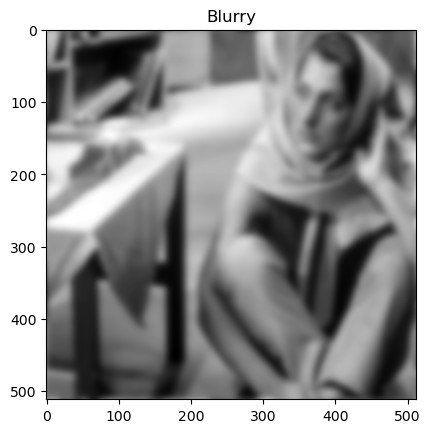

In [14]:
plt.plot()
plt.imshow(y1_bl, cmap='gray')
plt.title('Blurry')
plt.show()

In [15]:
# y1_bl

In [16]:
# scale(y1_bl)

In [17]:
# y1_bl.shape

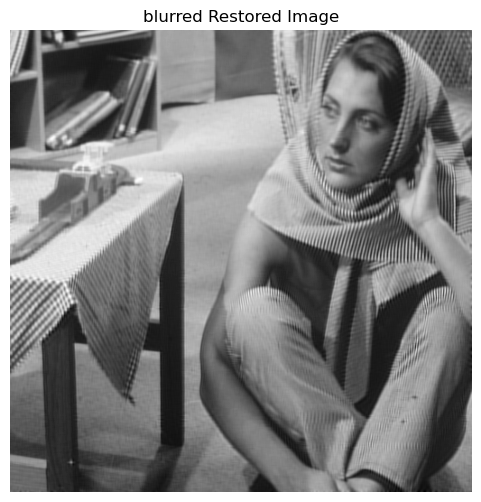

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift


# sigma = 5
# n = y1_bl.shape[0]
# t = np.concatenate( (np.arange(0, n/2+1), np.arange(-n/2, -1)) )
# y, x = np.meshgrid(t, t)
# h = np.exp( -(x**2+y**2)/(2.0*float(sigma)**2) )
# h = h / np.sum(h)
# hf = np.real(np.fft.fft2(h))



# Fourier transform of the blurred image
Y = fft2(y1_bl)

epsilon = 1e-8
H_conj = np.conj(hf)
X_hat = (H_conj * Y) / (H_conj * hf + epsilon)

# Inverse Fourier transform to get the original restored image
x_restored = np.real(ifft2(X_hat))

plt.figure(figsize=(6, 6))
plt.imshow(x_restored, cmap='gray')
plt.title('blurred Restored Image')
plt.axis('off')
plt.show()


Add white Gaussian noise ($\sigma=10$) to the blurred image $y$ of the previous question. Compute again the exact solution $\hat{x}$ that satisfies $\nabla J(\hat{x})=0$, using FFT. What do you observe?

In [19]:
sigma = 10

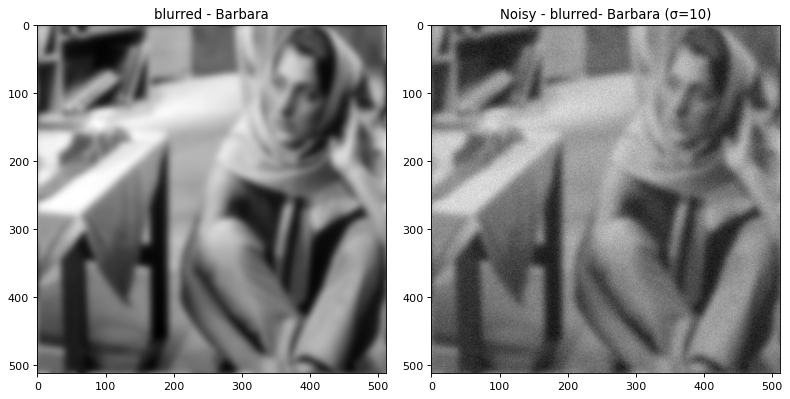

In [20]:
noise = sigma * np.random.randn(*y1_bl.shape) 

y1_bl_noisy = y1_bl + noise



plt.figure(figsize=(10, 5), dpi=80)

plt.subplot(121)
plt.imshow(y1_bl, cmap='gray')
plt.title('blurred - Barbara')

plt.subplot(122)
plt.imshow(y1_bl_noisy, cmap='gray')
plt.title(f'Noisy - blurred- Barbara (σ={sigma})')

plt.tight_layout()
plt.show()


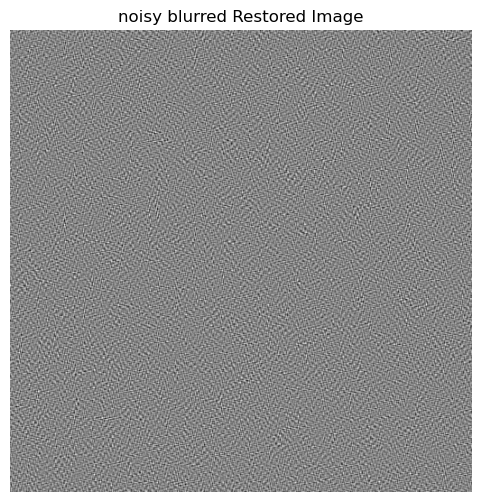

In [21]:

# sigma = 5
# n = y1_bl_noisy.shape[0]
# t = np.concatenate( (np.arange(0, n/2+1), np.arange(-n/2, -1)) )
# y, x = np.meshgrid(t, t)
# h = np.exp( -(x**2+y**2)/(2.0*float(sigma)**2) )
# h = h / np.sum(h)
# hf = np.real(np.fft.fft2(h))



# Fourier transform of the noisy blurred image
Y = fft2(y1_bl_noisy)

epsilon = 1e-8
H_conj = np.conj(hf)
X_hat = (H_conj * Y) / (H_conj * hf + epsilon)

# Inverse Fourier transform to get the noisy blurred restored image
x_restored = np.real(ifft2(X_hat))

plt.figure(figsize=(6, 6))
plt.imshow(x_restored, cmap='gray')
plt.title('noisy blurred Restored Image')
plt.axis('off')
plt.show()


#### Gradient Descent algorithm
In order to find the minimum, instead of using Exact Least Square solution, we can make use of the gradient descent algorithm. Recall that it is an iterative algorithm, where each update is given by:

\begin{equation}
 x_{k+1} = x_k - \alpha 2 A^*(A x_k - y)
\end{equation}

with $k = 0 \dots K-1$, $x_0 = y$ and $0 < \alpha \leq \frac{1}{2}$.

Complete the gradient descent function below, plot the cost/error function along with the resulting image. Ensure that the cost function consistently decreases (debug your code if necessary!). What observations can you make for different values of K?

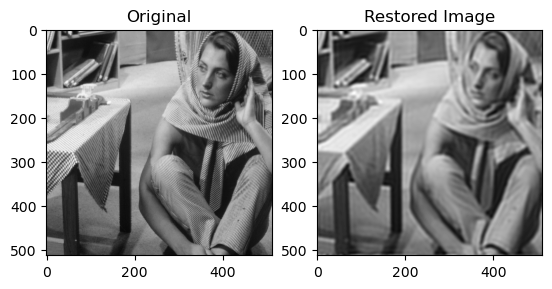

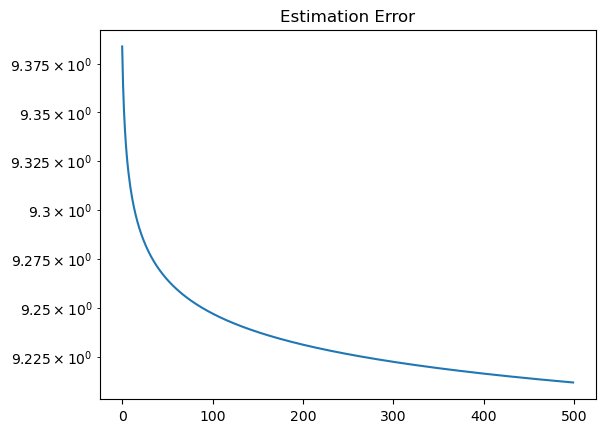

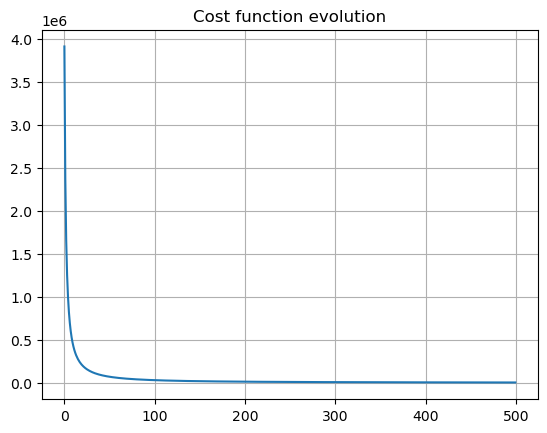

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Gradient Descent Parameters
alpha = 0.4  # Step 
K = 500      # Number of iterations

x1 = x1
y =y1_bl

# Initialization
xk = y1_bl  # (noisy blurred image)
J = np.zeros(shape=(K))  # Cost 
err = np.zeros(shape=(K))  # error

# Gradient Descent 
# Main loop
k = 0
while k < K:
    gradJ = 2 * np.real(np.fft.ifft2(np.conj(hf ) * ((hf * (fft.fft2(xk))) - fft.fft2(y))))  # 2 * A* (Axk - y)  
    
    # update xk
    xk = xk - alpha * gradJ  
    # Calculate cost J(xk) and estimation error
    J[k] = np.linalg.norm(np.real(np.fft.ifft2(hf*np.fft.fft2(xk)) - y))**2  #  Cost function
    err[k] = np.linalg.norm(xk - x1)  # Error between xk and original image  
    k += 1

# -- plots
# plot x
plt.subplot(121)
plt.imshow(x1, cmap='gray')
plt.title('Original')
# plot xk
plt.subplot(122)
plt.imshow(xk, cmap= 'gray')
plt.title('Restored Image')
plt.show()

# Estimation Error
plt.figure()
plt.semilogy(np.log(err))
plt.title('Estimation Error')

# Cost Function
plt.figure()
plt.plot(J)
plt.title('Cost function evolution')
plt.grid(True)

* Write your answer here

**observations**

Cost Function Behavior:
- The cost \( J(x_k) \) decreases consistently, ensuring convergence of the algorithm.
- A non-decreasing cost function indicates issues like an improperly chosen \( \alpha \) (step size).

Effect of \( K \) (Number of Iterations):
- For small \( K \), the restoration is incomplete (blurry image).
- Larger \( K \) improves restoration, but excessive iterations may amplify noise (if \( \alpha \) is not appropriately tuned).



### Tikhonov regularisation


We now consider the following penalised criterion $$\mathcal{J}(x):= \|Ax-y\|_2^2 + \lambda\mathcal{R}(x)$$ where $\mathcal{R}(\cdot)$ is a regularisation term. 


* Explain why this term is introduced.


**Write your answer here**

**Mitigating Ill-posedness:**
   - Many inverse problems, such as image deblurring, are ill-posed. This means small changes in the input \( y \) (e.g., noise) can cause large variations in the solution \( x \).
   - Regularization introduces a constraint or prior on \( x \) to stabilize the problem and make it well-posed.

**Handling Noise:**
   - The term \( \|Ax - y\|_2^2 \) ensures the solution fits the observed data \( y \), but it is sensitive to noise.
   - The regularization term \( λ \mathcal{R}(x) \) helps control the influence of noise by discouraging overly complex or noisy solutions.


**Balancing Fit vs. Regularization ( λ ):**
   - The parameter ( λ > 0  controls the trade-off between:
     - **Data fidelity** (\( \|Ax - y\|_2^2 \)): Ensures the solution fits the observed data.
     - **Regularization** (\( \mathcal{R}(x) \)): Encourages solutions that adhere to prior knowledge or desired constraints.

We consider these two regularisation terms in this lab: 
\begin{align*}
    \mathcal{R}_1(x) &=  \|x\|_2^2 \\
    \mathcal{R}_2(x) &=  \|\nabla x\|_2^2
\end{align*}
where $\lambda>0$ is a regularisation parameter that controls the weight of the regularisation, and $$\|\nabla x \|_2 = \sum_{i,j}((\nabla x)_{i,j})^2$$
with
\begin{align}
&(\nabla x)_{i,j} = \big( (\nabla x)_{i,j}^1,(\nabla x)_{i,j}^2 \big)\\
&(\nabla x)_{i,j}^1 = (x_{i+1,j}-x_{i,j})\quad\text{if}\quad i<N,\qquad 0 \quad\text{if}\quad i=N \\
&(\nabla x)_{i,j}^2 = (x_{i,j+1}-x_{i,j})\quad\text{if}\quad j<N,\qquad 0 \quad\text{if}\quad j=N \\
\end{align}
where $N \times N$ is the size of the image.

* Compute their gradients and then complete the following python functions.

In [23]:
import numpy as np

def reg_1(x):
    return np.sum(x**2)

def grad_reg_1(x):
    return 2 * x

def reg_2(x):

    grad_x = np.diff(x, axis=0, append=0)  
    grad_y = np.diff(x, axis=1, append=0)  
    return np.sum(grad_x**2 + grad_y**2)

def grad_reg_2(x):
    grad_x = np.diff(x, axis=0, append=0)  
    grad_y = np.diff(x, axis=1, append=0)  

    # Gradients for the finite differences
    grad_x_back = -np.diff(grad_x, axis=0, prepend=0)
    grad_y_back = -np.diff(grad_y, axis=1, prepend=0)

    return 2 * (grad_x_back + grad_y_back)


* Modify the Gradient Descent function slightly to take into account $\mathcal{R}_1(\cdot)$.

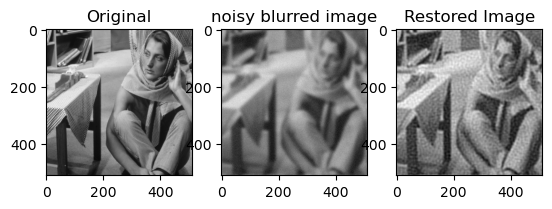

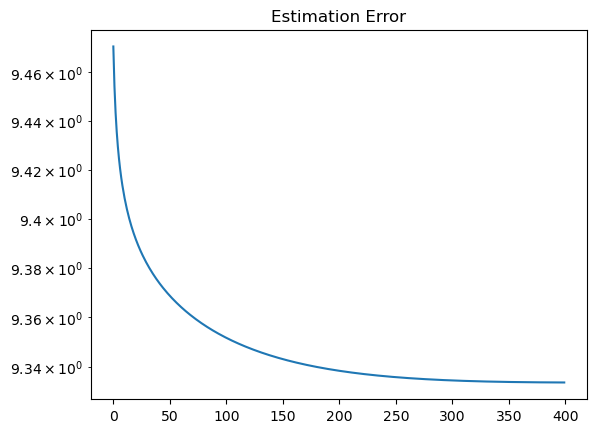

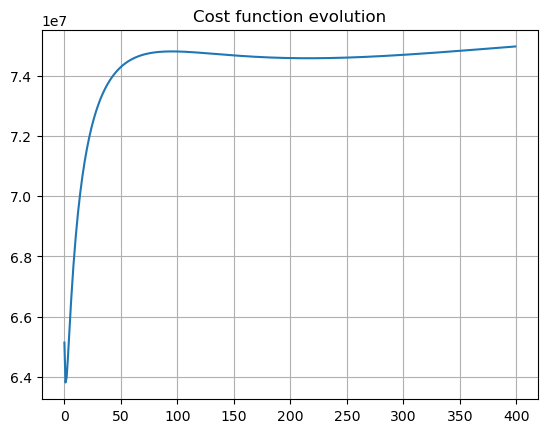

In [24]:
# -- Gradient Descent algo (R_1(.))




#-- Parameters
alpha = 0.4                   # Step
K = 400                       # Number of iterations
lambd = 0.005

# Initialisation
xk_tn = y1_bl_noisy  # tikhonov-nograd initialisation
J = np.zeros(shape=(K))    # Cost
err = np.zeros(shape=(K))  # Error




    
# Main loop
k = 0
while k < K:
    Ax = np.real(np.fft.ifft2(hf * np.fft.fft2(xk_tn)))
    fidelity_grad = 2 * np.real(np.fft.ifft2(hf * np.fft.fft2(Ax - y1_bl_noisy)))

    # Total gradient: fidelity + regularization
    gradJ = fidelity_grad + lambd * grad_reg_1(xk_tn)

    # Update step
    xk_tn = xk_tn - alpha * gradJ
    # Calculate cost and Error
    J[k] = np.linalg.norm(Ax - xk_tn)**2 + lambd * reg_1(xk_tn)  # Cost function
    err[k] = np.linalg.norm(xk_tn - x1)  # Error between restored and original image

    k += 1


# -- plots
# plot x
plt.subplot(131)
plt.imshow(x1, cmap='gray')
plt.title('Original')

plt.subplot(132)
plt.imshow(y1_bl_noisy, cmap='gray')
plt.title('noisy blurred image')

# plot xk
plt.subplot(133)
plt.imshow(xk_tn, cmap= 'gray')
plt.title('Restored Image')
plt.show()

# Estimation Error
plt.figure()
plt.semilogy(np.log(err))
plt.title('Estimation Error')

# Cost Function
plt.figure()
plt.plot(J)
plt.title('Cost function evolution')
plt.grid(True)


* Modify the Gradient Descent function slightly to take into account $\mathcal{R}_2(\cdot)$.

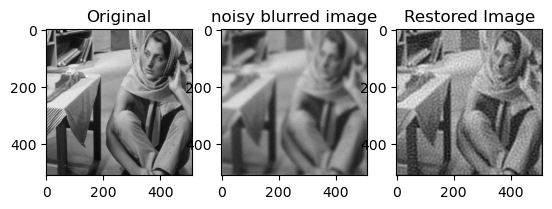

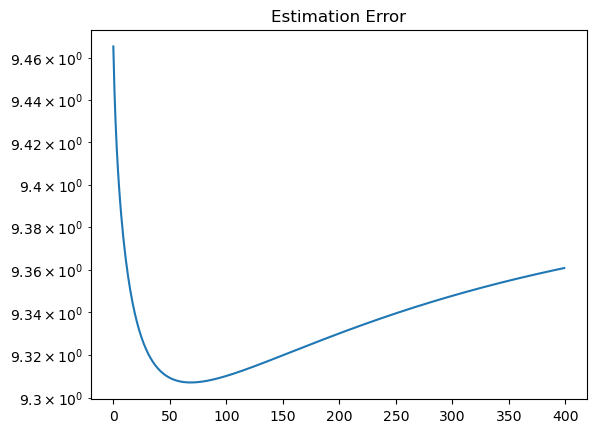

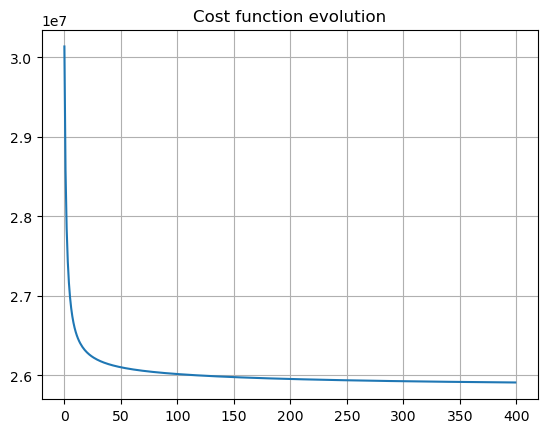

In [26]:
# -- Gradient Descent algo (R_2(.))

# -- Parameters
alpha = 0.4                  # Step size
K = 400                      # Number of iterations
lambd = 0.01                 

y1 = y1_bl_noisy

# Initialization
xk_tg = y1  # Initialize with the noisy image
J = np.zeros(K)  # Cost 
err = np.zeros(K)  # Error 

    
# Main loop
k = 0
while k < K:
   #  gradient
    fidelity_grad = 2*np.real(np.fft.ifft2(np.conj(hf )*np.fft.fft2(np.fft.ifft2(hf*np.fft.fft2(xk_tg))-y1)))


    gradJ = fidelity_grad + lambd * grad_reg_2(xk_tg)
    # update xk
    xk_tg = xk_tg - alpha*gradJ
    # Calculate cost and Error
    J[k] = np.linalg.norm(np.real(np.fft.ifft2(hf*np.fft.fft2(xk_tg))-y1))**2 + lambd*reg_2(xk_tn) #  Cost function
    err[k] = np.linalg.norm(xk_tg-x1)  # error between xk and the original image
    k += 1




# -- plots
# plot x

plt.subplot(131)
plt.imshow(x1, cmap='gray')
plt.title('Original')

plt.subplot(132)
plt.imshow(y1_bl_noisy, cmap='gray')
plt.title('noisy blurred image')

# plot xk
plt.subplot(133)
plt.imshow(xk_tg, cmap= 'gray')
plt.title('Restored Image')
plt.show()


# Estimation Error
plt.figure()
plt.semilogy(np.log(err))
plt.title('Estimation Error')

# Cost Function
plt.figure()
plt.plot(J)
plt.title('Cost function evolution')
plt.grid(True)

* Modify $\lambda$ to observe the influence. 

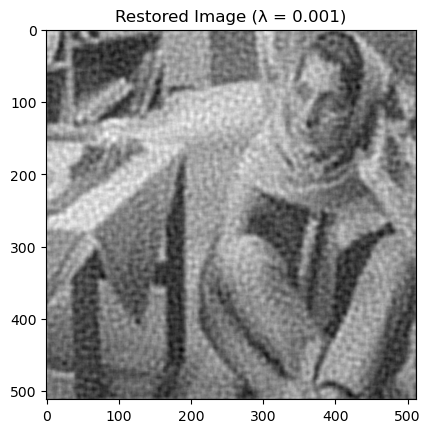

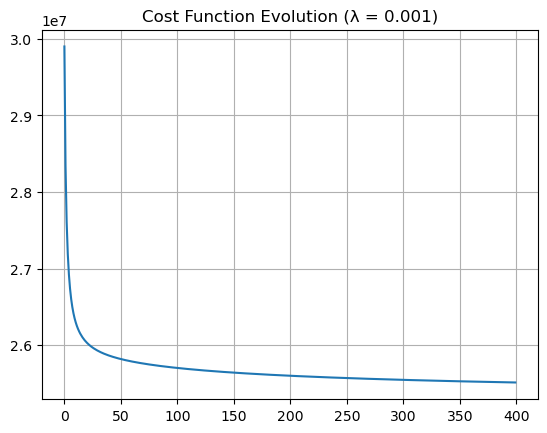

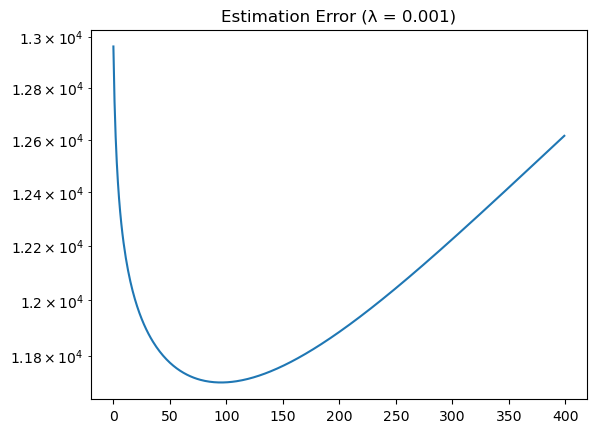

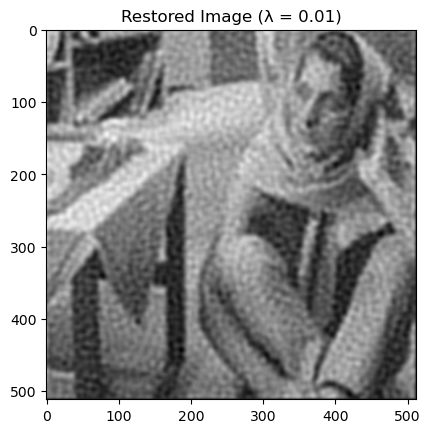

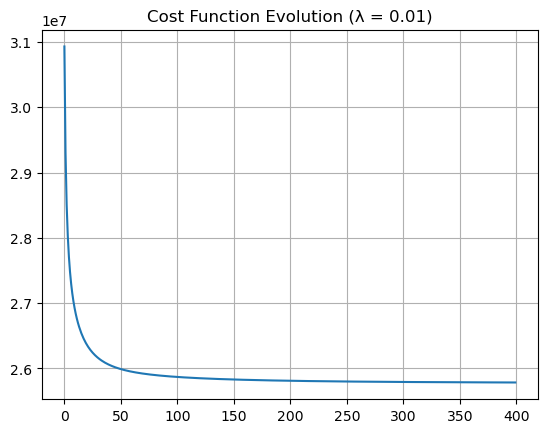

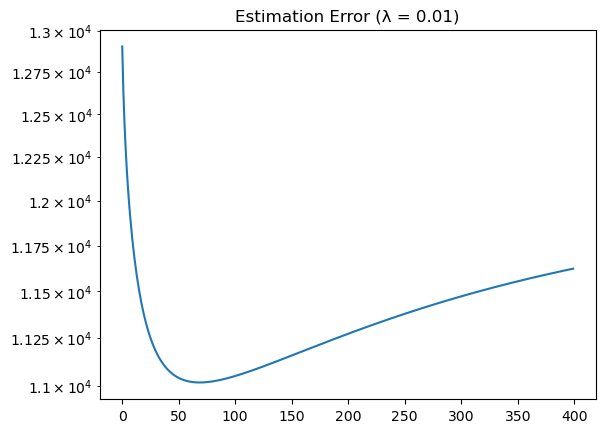

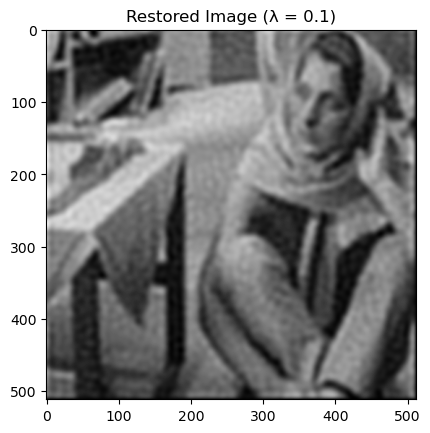

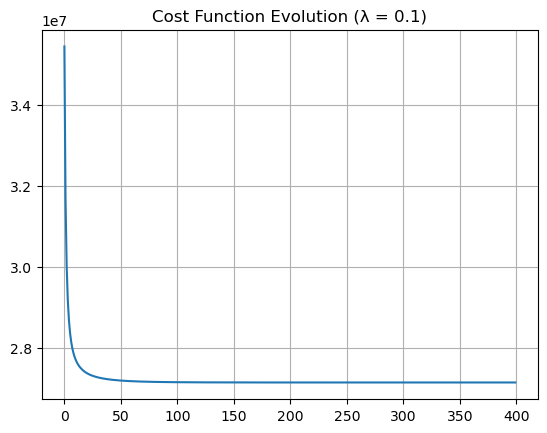

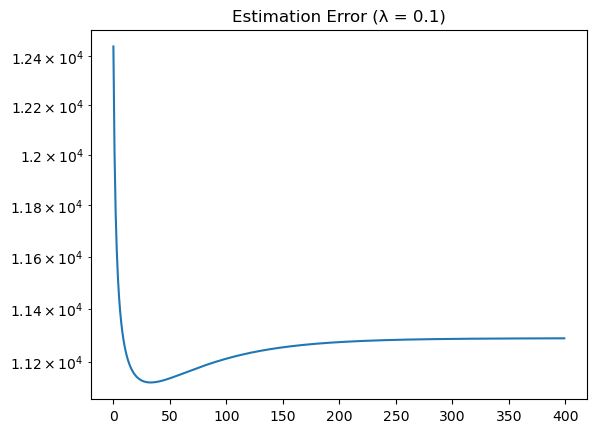

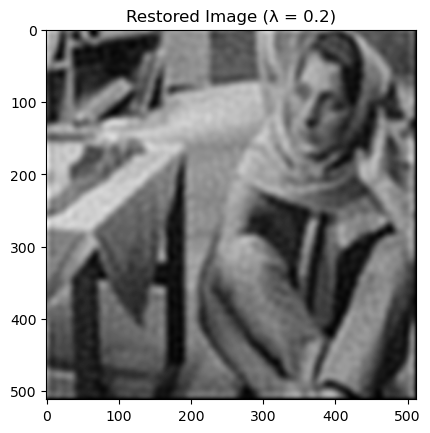

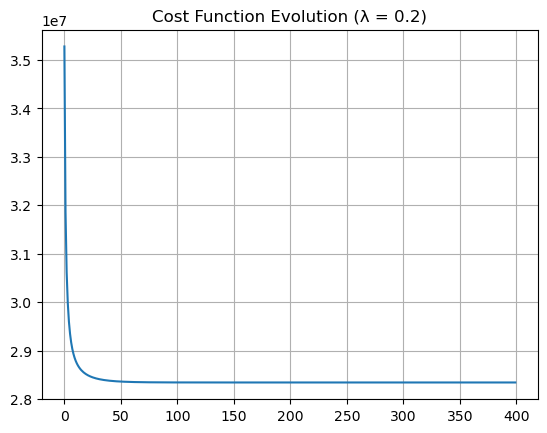

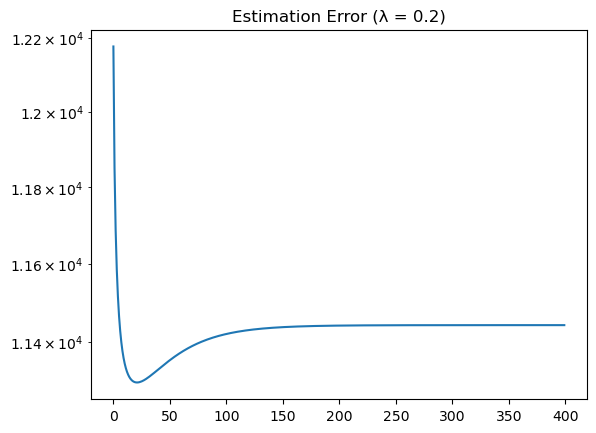

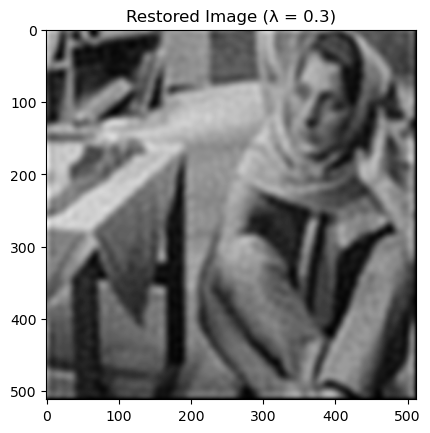

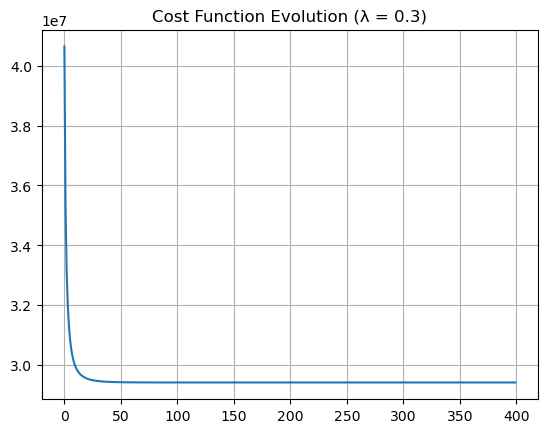

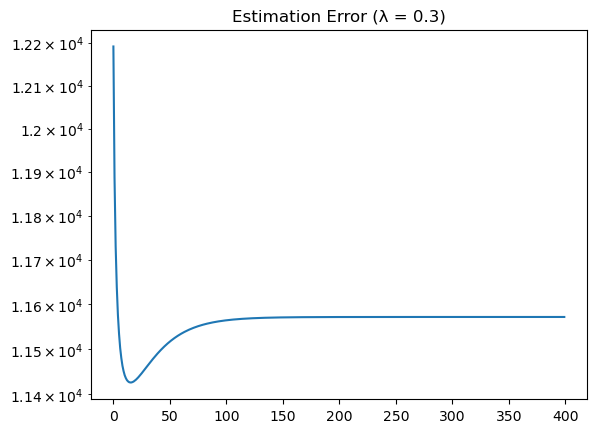

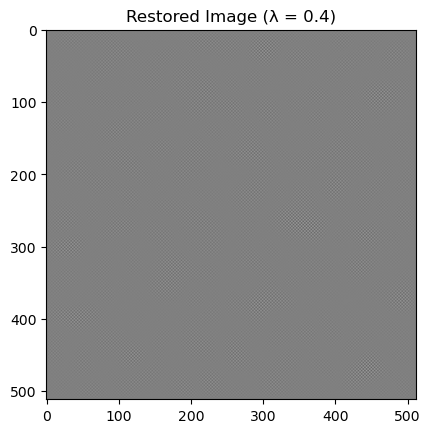

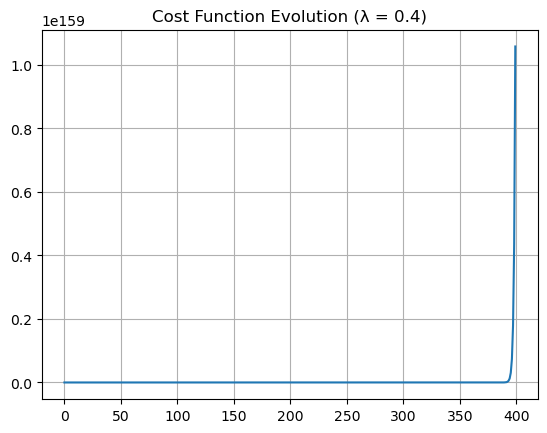

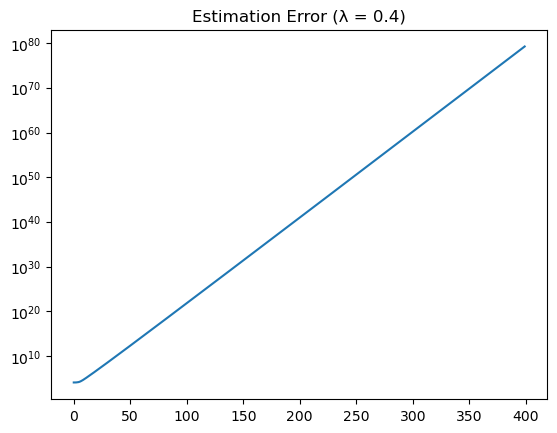

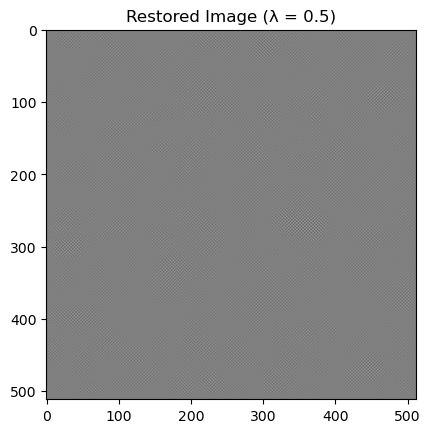

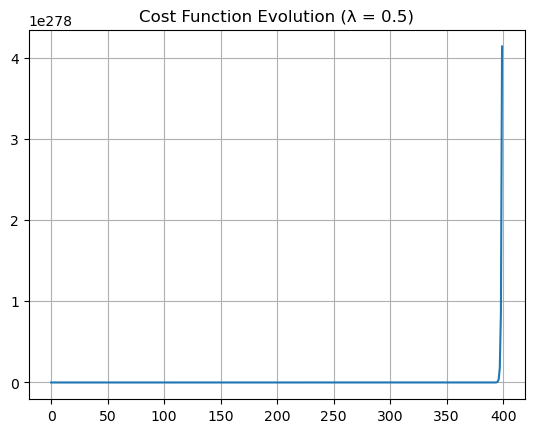

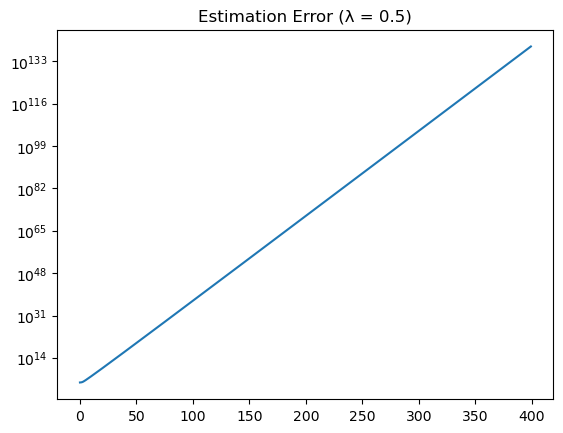

In [27]:
lambda_values = [0.001, 0.01, 0.1, 0.2,0.3,0.4,0.5]

for lambd in lambda_values:
    # Initialization
    xk_tg = y1  # Noisy image as initialization
    J = np.zeros(K)  # Cost function
    err = np.zeros(K)  # Error

    k = 0
    while k < K:
        fidelity_grad = 2 * np.real(np.fft.ifft2(np.conj(hf) * np.fft.fft2(np.fft.ifft2(hf * np.fft.fft2(xk_tg)) - y1)))

        gradJ = fidelity_grad + lambd * grad_reg_2(xk_tg)

        # Update step
        xk_tg = xk_tg - alpha * gradJ

        J[k] = np.linalg.norm(np.real(np.fft.ifft2(hf * np.fft.fft2(xk_tg)) - y1))**2 + lambd * reg_2(xk_tg)
        err[k] = np.linalg.norm(xk_tg - x1)  

        k += 1

    # Plot the restored image for each lambda
    plt.figure()
    plt.imshow(xk_tg, cmap='gray')
    plt.title(f'Restored Image (λ = {lambd})')
    plt.show()

    # Plot the cost function evolution
    plt.figure()
    plt.plot(J)
    plt.title(f'Cost Function Evolution (λ = {lambd})')
    plt.grid(True)
    plt.show()

    # Plot estimation error
    plt.figure()
    plt.semilogy(err)
    plt.title(f'Estimation Error (λ = {lambd})')
    plt.show()


**Observations**

- **Low λ:**
  - The restored image might retain more noise.
  - Cost function reduces faster but might stabilize at a higher value.

- **High λ:**
  - The restored image becomes smoother (denoised), but fine details could be lost.
  - Cost function evolves more slowly and may stabilize at a lower value.
  - Here after λ = 0.4 the image is not able to restore 

* Observe the restored images, and compare them to the true image by computing the SNR. 

C:\Users\praba\AppData\Local\Temp\ipykernel_52040\2694038387.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


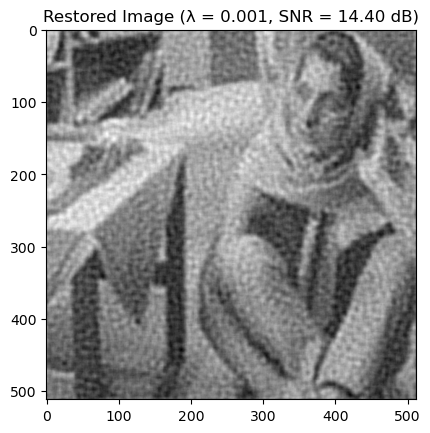

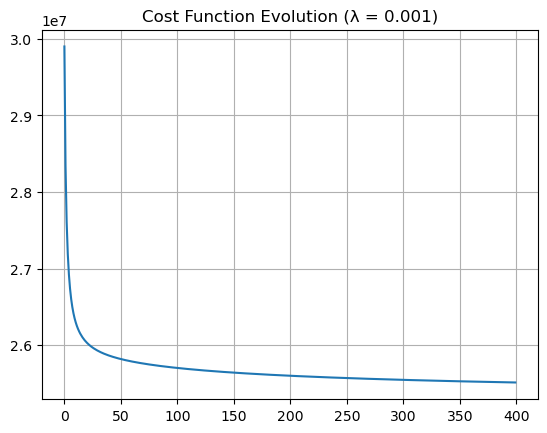

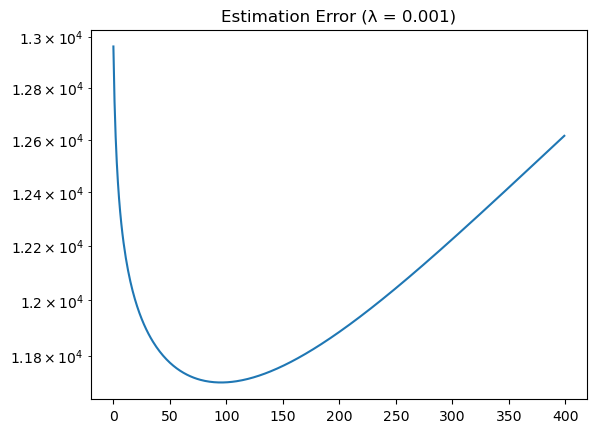

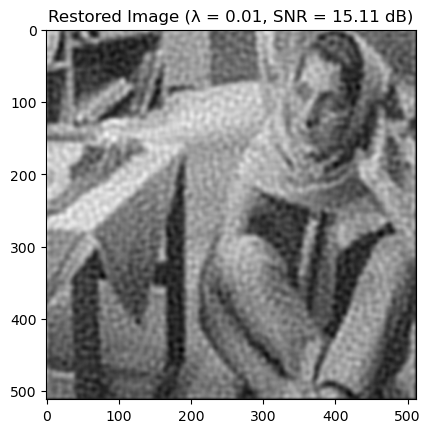

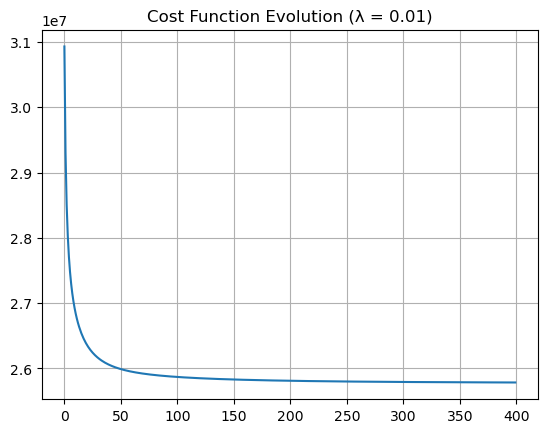

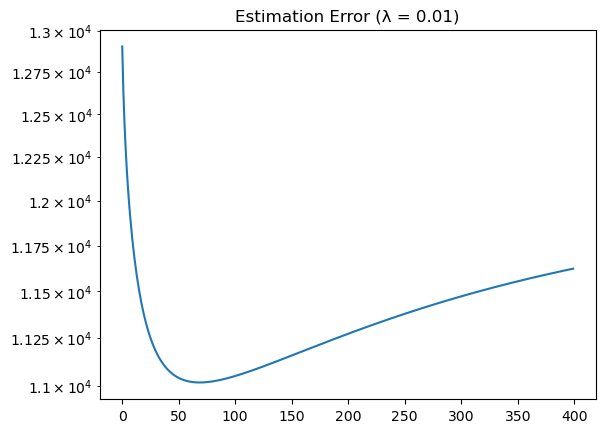

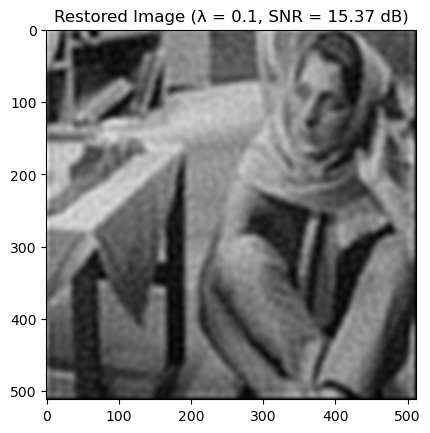

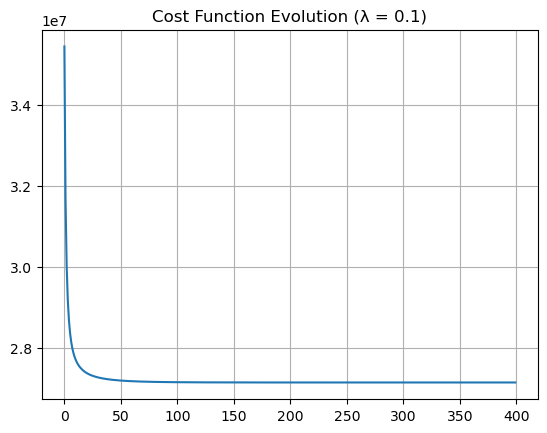

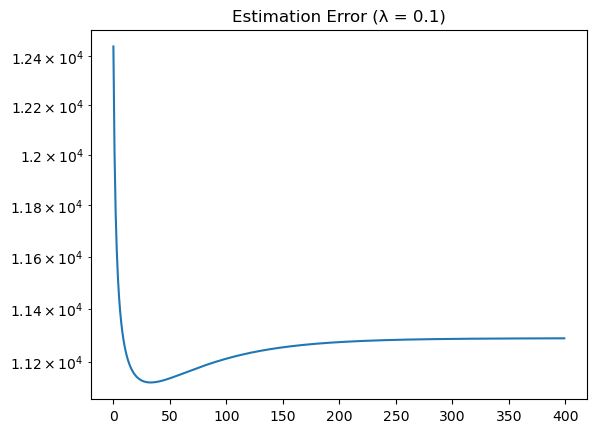

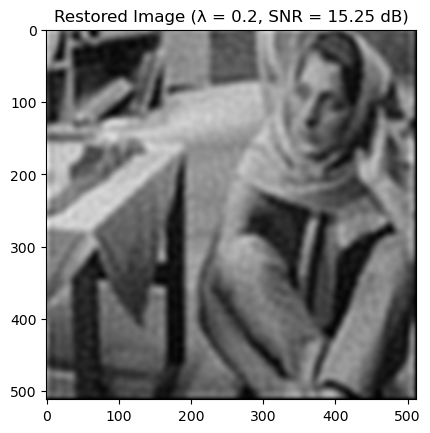

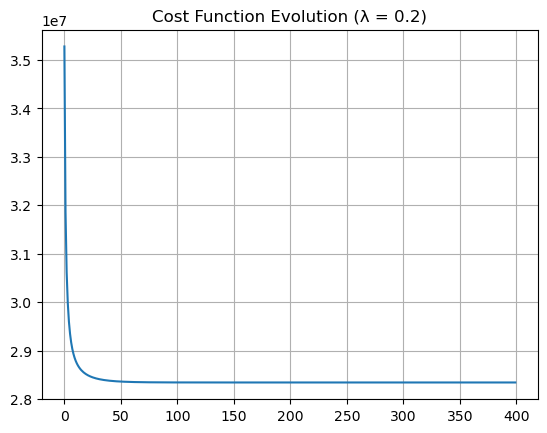

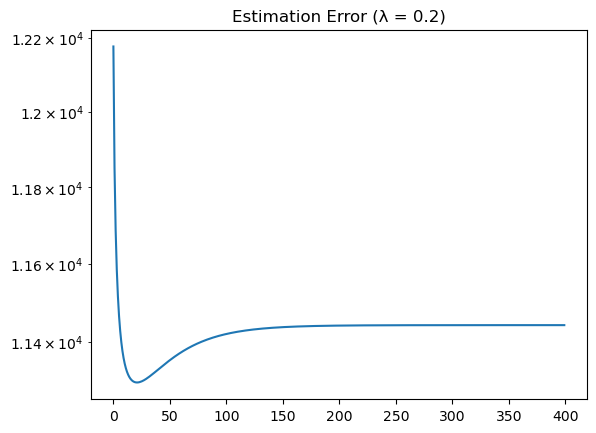

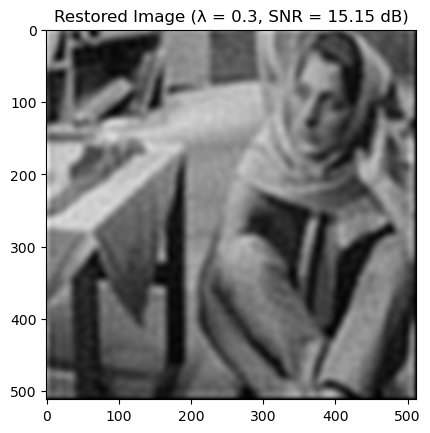

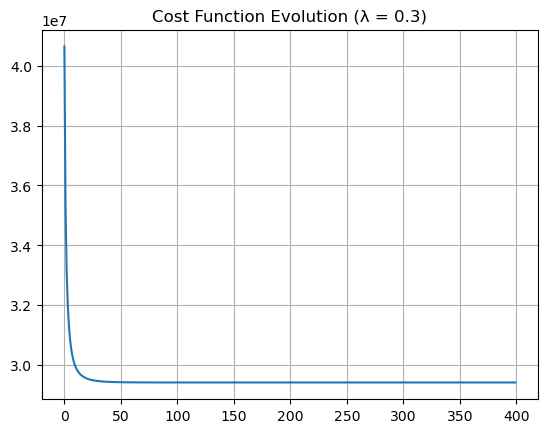

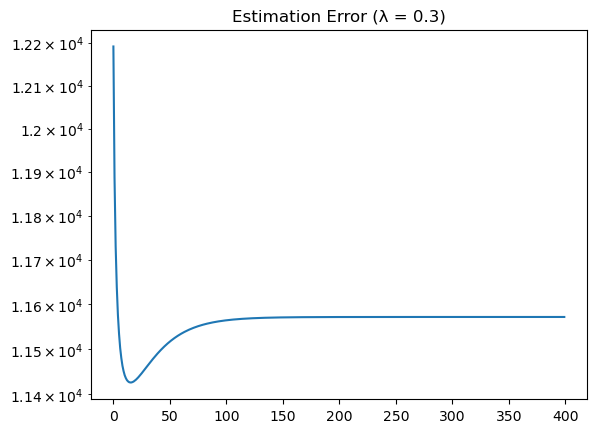

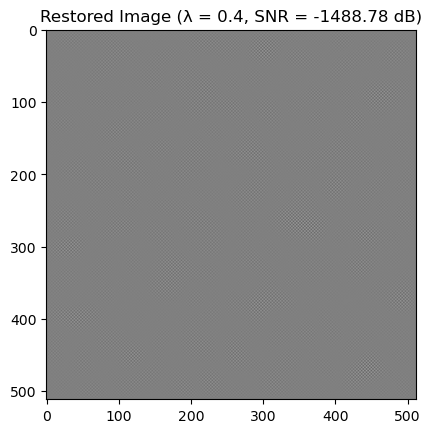

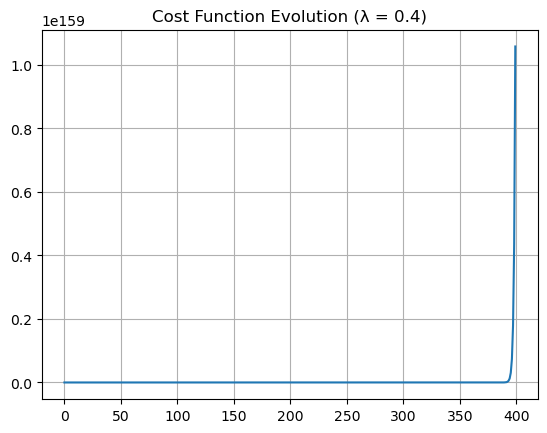

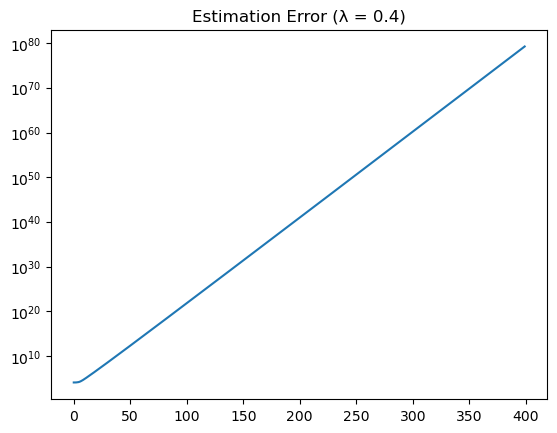

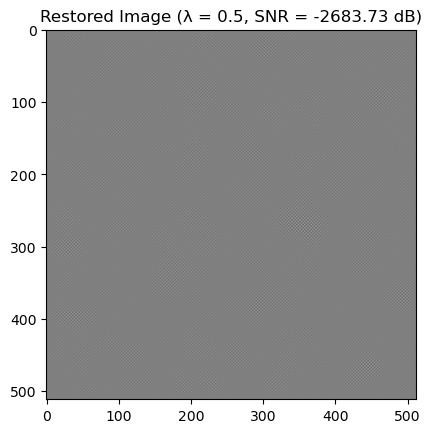

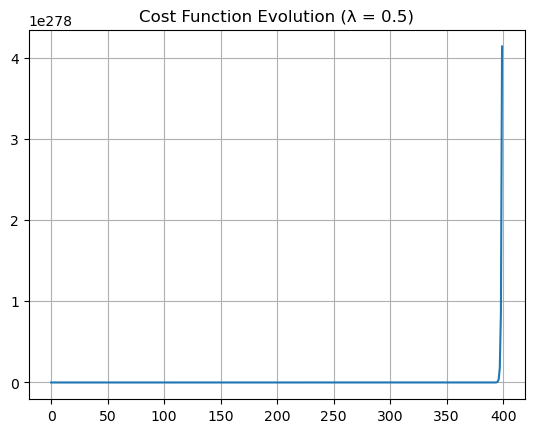

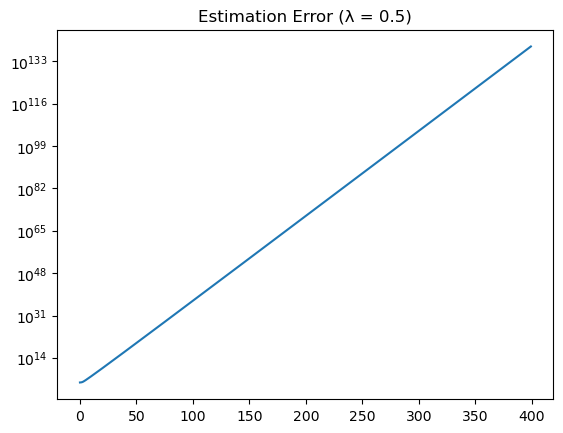

λ = 0.001, SNR = 14.40 dB
λ = 0.01, SNR = 15.11 dB
λ = 0.1, SNR = 15.37 dB
λ = 0.2, SNR = 15.25 dB
λ = 0.3, SNR = 15.15 dB
λ = 0.4, SNR = -1488.78 dB
λ = 0.5, SNR = -2683.73 dB


In [28]:
lambda_values = [0.001, 0.01, 0.1, 0.2,0.3,0.4,0.5]

snr_values = []

for lambd in lambda_values:
    # Initialization
    xk_tg = y1  # Noisy image as initialization
    J = np.zeros(K)  # Cost 
    err = np.zeros(K)  # Error

    k = 0
    while k < K:
        fidelity_grad = 2 * np.real(np.fft.ifft2(np.conj(hf) * np.fft.fft2(np.fft.ifft2(hf * np.fft.fft2(xk_tg)) - y1)))

        gradJ = fidelity_grad + lambd * grad_reg_2(xk_tg)

        # Update step
        xk_tg = xk_tg - alpha * gradJ

        J[k] = np.linalg.norm(np.real(np.fft.ifft2(hf * np.fft.fft2(xk_tg)) - y1))**2 + lambd * reg_2(xk_tg)
        err[k] = np.linalg.norm(xk_tg - x1)  

        k += 1

    # Compute SNR
    snr = 10 * np.log10(np.linalg.norm(x1)**2 / np.linalg.norm(x1 - xk_tg)**2)
    snr_values.append(snr)

    # Plot the restored image for each lambda
    plt.figure()
    plt.imshow(xk_tg, cmap='gray')
    plt.title(f'Restored Image (λ = {lambd}, SNR = {snr:.2f} dB)')

    # Plot the cost function evolution
    plt.figure()
    plt.plot(J)
    plt.title(f'Cost Function Evolution (λ = {lambd})')
    plt.grid(True)

    # Plot estimation error
    plt.figure()
    plt.semilogy(err)
    plt.title(f'Estimation Error (λ = {lambd})')

plt.show()

for i, lambd in enumerate(lambda_values):
    print(f"λ = {lambd}, SNR = {snr_values[i]:.2f} dB")
